# Variational inference assignment

In this assignment, we are going to implement variational inference on a synthetic problem.


## Software setup
This assignment will be run in Python 3, and we might need to install a few Python packages.
To avoid interference with other system packages, we basically have two alternatives.
We can setup a virtual environment with tools like `virtualenv` or `anaconda`.
Alternatively, we can use online Python interpreters, like Google Colab.

If you decide to use [Google Colab](https://colab.research.google.com), you may follow these instructions.

<b>Instructions:</b>
1. Head to Google Colab at: https://colab.research.google.com
2. If you do not have a Google account, you might have to create one.
3. Login with your account
4. At the Welcome screen, select the Upload tab and then upload this notebook file.
5. If you miss the Welcome screen, at the Google Colab notebook view, you can go to:
File -> Upload...

In [1]:
import torch    # PyTorch: for linear algebra operations and automatic differentiation
import torch.distributions as td    # PyTorch's probability distributions package
import matplotlib.pyplot as plt     # Matplotlib's Python plotting package
from tqdm.notebook import trange    # progress bars
import numpy as np

In [2]:
# Auxiliary function for plotting

def make_grid(x_lb, x_ub, sx, y_lb=None, y_ub=None, sy=None, centred=True):
    """
    Auxiliary function to create a regular 2D spatial grid to plot predictions
    """
    if y_lb is None:
        y_lb = x_lb
    if y_ub is None:
        y_ub = x_ub
    if sy is None:
        sy = sx

    xs, ys = np.mgrid[x_lb:x_ub:sx, y_lb:y_ub:sy].astype('float')
    if centred:
        xs += 0.5 * sx
        ys += 0.5 * sy
    np_array = np.vstack((xs.ravel(), ys.ravel())).T

    return torch.tensor(np_array, dtype=torch.get_default_dtype())

## Problem setting
Given a log-likelihood and a log-prior probability density, your task is to estimate a multivariate Gaussian
approximation to the posterior via variational inference.
The log-likelihood for this assignment is Rosenbrock's banana shape function on a 2-dimensional space.

In [3]:
def log_likelihood(x: torch.Tensor):
    """
    Log-likelihood function

    :param x: a S-by-2 matrix, where S represents the number of samples
    :return: a S-array with the log-likelihood value for each sample
    """
    assert len(x.shape) == 2, "x must be a 2D array"
    assert x.shape[1] == 2, "x must have 2 columns, one for each coordinate"
    return -((x[:,0]**2 - x[:,1])**2 + (x[:,0] - 1)**2)

In [4]:
# Plotting grid

x_lb = -10
x_ub = 10
y_lb = -10
y_ub = 15

spacing = 0.05

vis_x = make_grid(x_lb, x_ub, spacing, y_lb, y_ub, spacing).cpu()
nx = int((x_ub-x_lb)/spacing)
ny = int((y_ub-y_lb)/spacing)

In [5]:
vis_log_like = log_likelihood(vis_x)

Text(0.5, 1.0, 'Log-likelihood')

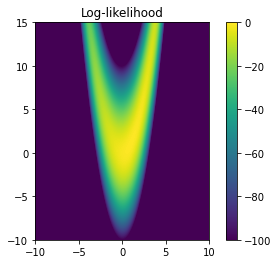

In [6]:
extent=[x_lb, x_ub, y_lb, y_ub]
plt.imshow(vis_log_like.reshape(nx, ny).t(), origin='lower', vmax=0, vmin=-100, extent=extent)
plt.colorbar()
plt.title("Log-likelihood")

<b>Prior:</b> As a prior, we will use a normal distribution.

In [7]:
def log_prior(x):
    """
    Log prior probability density

    :param x: a S-by-2 matrix, where S represents the number of samples
    :return: a S-array with the log-probability density for each sample
    """
    assert len(x.shape) == 2, "x must be a 2D array"
    assert x.shape[1] == 2, "x must have 2 columns, one for each coordinate"
    return td.Normal(0, 4).log_prob(x).sum(dim=1)

Text(0.5, 1.0, 'Unnormalised log-posterior probability density')

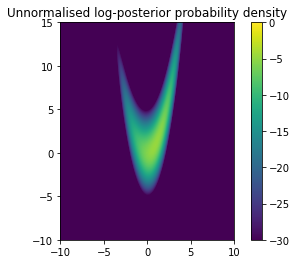

In [8]:
vis_log_prior = log_prior(vis_x)

plt.imshow(vis_log_like.reshape(nx, ny).t()+vis_log_prior.reshape(nx, ny).t(), origin='lower', vmax=0, vmin=-30, extent=extent)
plt.colorbar()
plt.title("Unnormalised log-posterior probability density")

In [9]:
vis_Log_posterior = vis_log_like.reshape(nx, ny).t()+vis_log_prior.reshape(nx, ny).t()

In [10]:
vis_Log_posterior.max(), vis_Log_posterior.min()

(tensor(-4.6650), tensor(-12116.1934))

<b>Task:</b> The task now is to implement and run variational inference using a multivariate normal as the variational
 distribution. The mean and covariance matrix of the variational distribution are to be optimised using PyTorch.
 You are allowed to reuse code from the tutorials.
 However, note that this is a 2-dimensional, instead of the unidimensional toy problem we had.

<b>Hint:</b> PyTorch provides `td.MultivariateNormal` and `td.Normal` as implementations of multivariate and univariate,
respectively, Gaussian distributions.
A parameter to give attention to is the covariance matrix $\Sigma$, which needs to be positive-definite.
There are a few ways to parameterise it with varying degrees of freedom.
To avoid further complications, for this assignment, you are allowed to simply use a single variational parameter
$c \in \mathbb{R}$ to parameterise the covariance matrix as:

\begin{equation*}
\Sigma := \exp(c)\mathbf{I}\,,
\end{equation*}

where the exponentiation ensures the matrix is positive-definite.

After estimating the variational distribution as `v_dist`,
run the following cell to compare the approximation with the unnormalised posterior.

In [11]:
# Unnormalised log-posterior probability density
def log_posterior(x):
    return log_likelihood(x) + log_prior(x)

In [12]:
def kl_divergence(samples,
                  p_distribution,
                  q_distribution):
    """
    :param samples: samples from the variational distribtuion
    :param p_distribution: probability distribution object representing the true posterior
    :param q_distribution: variational distribution object
    :return: an empirical approximation of the KL divergence between the variational distribution and the true posterior
    """
    return (q_distribution.log_prob(samples) - p_distribution(samples)).mean()

In [13]:
#TODO: Implement ELBO computation and training loop
q_mean = torch.randn([2], requires_grad=False)
c_param = torch.randn([], requires_grad=True)
q_sd = torch.exp(c_param) * torch.diag(torch.tensor([1,1]))

n_iterations = 1000   # number of iterations to run gradient descent for
opt = torch.optim.Adam([c_param], lr=1e-1) # optimisation algorithm
n_samples = 20000     # number of samples of the variational distribution to compute the KL divergence with

losses = torch.zeros(n_iterations)

pbar = trange(n_iterations)
for t in pbar:
    opt.zero_grad()
    v_dist = td.MultivariateNormal(q_mean, q_sd)
    # the rsample() method applies the reparameterisation trick
    # so that we can differentiate through the samples
    q_samples = v_dist.rsample([n_samples])

    loss = kl_divergence(q_samples, log_posterior, v_dist) # KL divergence empirical approximation
    loss.backward(retain_graph=True)
    opt.step()
    losses[t] = loss.item()
    pbar.set_postfix(loss=loss.item())

Text(0.5, 1.0, 'Variational approximation')

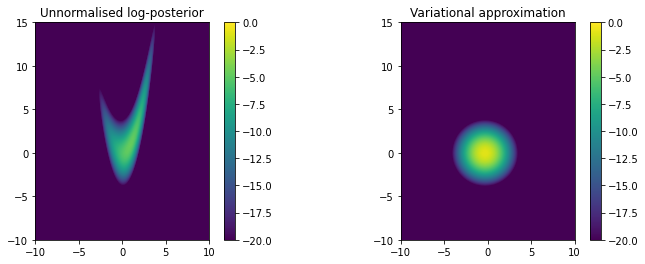

In [14]:
plt.figure(figsize=(12,4))
with torch.no_grad():
    vis_variational = v_dist.log_prob(vis_x)
plt.subplot(121)
plt.imshow(vis_log_like.reshape(nx, ny).t()+vis_log_prior.reshape(nx, ny).t(), origin='lower',
            vmax=0, vmin=-20, extent=extent)
plt.colorbar()
plt.title("Unnormalised log-posterior")

plt.subplot(122)
plt.imshow(vis_variational.reshape(nx, ny).t(), origin='lower', vmax=0, vmin=-20,
            extent=extent)
plt.colorbar()
plt.title("Variational approximation")

# Losses

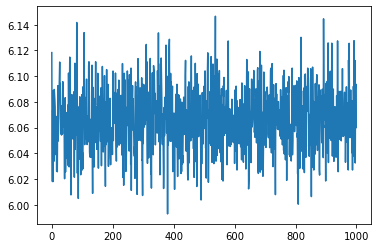

In [15]:
plt.plot(losses)
plt.show()